# Face recognition

In [18]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Loading data set
from sklearn.datasets import fetch_lfw_people
# Data set with faces
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

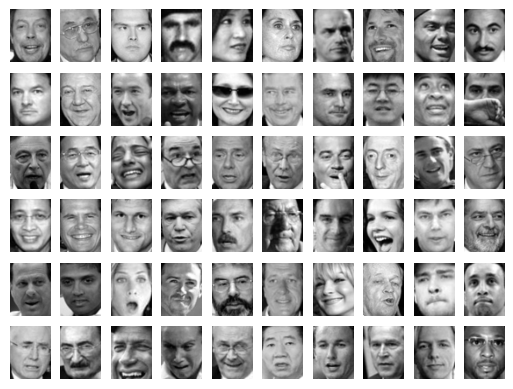

In [54]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[i], cmap='gray')
    axi.axis('off')

Getting images without faces

In [49]:
from skimage import data, transform, color, feature
import skimage.data
# Sets without faces
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock',
               'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field',
              'rocket', 'horse']
raw_images = (getattr(data, name)() for name in imgs_to_use)
images = [color.rgb2gray(image) if image.ndim == 3 else image
          for image in raw_images]

In [16]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) 
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale) 
                              for im in images for scale in [0.5, 1.0, 2.0]])

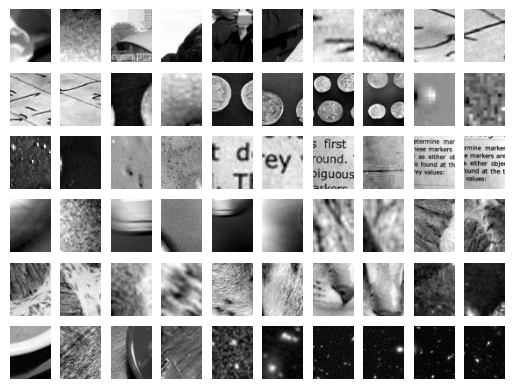

In [56]:
# Showing images without face
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

Creating datasets for lea

In [57]:
from itertools import chain
# Union features from 2 datasets
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [26]:
X_train.shape

(43233, 1215)

### Gaussian Naive Bayes classifier

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.95663236, 0.972476  , 0.97363247, 0.97640527, 0.97536433])

### Linear Support Vector Classification

In [30]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(dual=False), {'C' : [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)

GridSearchCV(estimator=LinearSVC(dual=False),
             param_grid={'C': [1.0, 2.0, 4.0, 8.0]})

In [36]:
grid.best_score_

0.9888279630756613

In [37]:
grid.best_params_

{'C': 2.0}

In [38]:
model = grid.best_estimator_
model.fit(X_train, y_train)
LinearSVC()

LinearSVC()

In [76]:
# Test image with face
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)

(-0.5, 139.5, 159.5, -0.5)

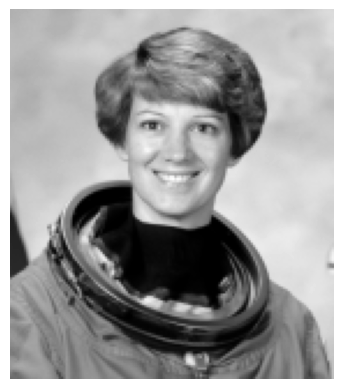

In [77]:
# Drawing image
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [78]:
def sliding_window(img ,patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [79]:
labels = model.predict(patches_hog)
labels.sum()

46.0

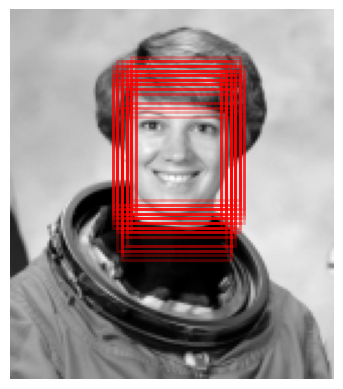

In [81]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
# Drawin rectangles
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))